In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler





This process provides a basic linear model to predict bike demand. Note that this is a simplified approach and there are many ways to improve it:

Feature engineering: Create more features like weather data, holidays, etc.
Handle seasonality: Use time series techniques to account for seasonal patterns.
Try other models: Random Forests, Gradient Boosting, etc., might perform better.
Cross-validation: Use time-based cross-validation for more robust evaluation.
Hyperparameter tuning: Expand the grid search to include more parameters.

In [2]:
# URL for a specific month's data
url = "https://s3.amazonaws.com/capitalbikeshare-data/202201-capitalbikeshare-tripdata.zip"

# Download the zip file
response = requests.get(url)

# Create a BytesIO object from the response content
zip_file = io.BytesIO(response.content)

# Create a ZipFile object
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    # Get the name of the CSV file (assuming it ends with .csv)
    csv_file_name = next(name for name in zip_ref.namelist() if name.endswith('.csv'))
    
    # Read the CSV file from within the zip
    with zip_ref.open(csv_file_name) as csv_file:
        df = pd.read_csv(csv_file)
print(df.head())

            ride_id rideable_type           started_at             ended_at  \
0  1B4445D591115BD9  classic_bike  2022-01-06 18:39:28  2022-01-06 18:43:03   
1  7F4A0E2F03EADEB7  classic_bike  2022-01-31 19:21:22  2022-01-31 19:27:33   
2  30DD8A84164843AD  classic_bike  2022-01-07 15:28:39  2022-01-07 15:31:01   
3  FC67665D7682D0A6  classic_bike  2022-01-27 20:09:25  2022-01-27 20:37:02   
4  7854F7CC4F631A1E  classic_bike  2022-01-07 16:14:28  2022-01-07 16:16:13   

                                  start_station_name  start_station_id  \
0                            Monroe Ave & Leslie Ave           31087.0   
1                                     14th & L St NW           31283.0   
2                                     14th & L St NW           31283.0   
3                        New York Ave & Hecht Ave NE           31518.0   
4  Falls Church City Hall / Park Ave & Little Fal...           32608.0   

                            end_station_name  end_station_id  start_lat  \
0    

## Exploratory Data Analysis (EDA):

## Exploratory Data Analysis (EDA):


In [3]:
# Basic info about the dataset
print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109619 entries, 0 to 109618
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ride_id             109619 non-null  object 
 1   rideable_type       109619 non-null  object 
 2   started_at          109619 non-null  object 
 3   ended_at            109619 non-null  object 
 4   start_station_name  103713 non-null  object 
 5   start_station_id    103713 non-null  float64
 6   end_station_name    102858 non-null  object 
 7   end_station_id      102858 non-null  float64
 8   start_lat           109619 non-null  float64
 9   start_lng           109619 non-null  float64
 10  end_lat             109419 non-null  float64
 11  end_lng             109419 non-null  float64
 12  member_casual       109619 non-null  object 
dtypes: float64(6), object(7)
memory usage: 10.9+ MB
None


In [4]:
# Summary statistics
print(df.describe())



       start_station_id  end_station_id      start_lat      start_lng  \
count     103713.000000   102858.000000  109619.000000  109619.000000   
mean       31365.377426    31367.437001      38.905736     -77.029462   
std          243.329957      242.308676       0.023631       0.029412   
min        31000.000000    31000.000000      38.780000     -77.368416   
25%        31203.000000    31208.000000      38.895620     -77.042452   
50%        31280.000000    31278.000000      38.905578     -77.029822   
75%        31607.000000    31609.000000      38.916476     -77.012108   
max        32609.000000    32901.000000      39.121327     -76.825535   

             end_lat        end_lng  
count  109419.000000  109419.000000  
mean       38.904689     -77.029262  
std         0.023324       0.029199  
min        38.710000     -77.368416  
25%        38.894972     -77.042581  
50%        38.903827     -77.029822  
75%        38.915000     -77.012108  
max        39.125828     -76.825535  


In [5]:
# Check for missing values
print(df.isnull().sum())


ride_id                  0
rideable_type            0
started_at               0
ended_at                 0
start_station_name    5906
start_station_id      5906
end_station_name      6761
end_station_id        6761
start_lat                0
start_lng                0
end_lat                200
end_lng                200
member_casual            0
dtype: int64


In [6]:

# Look at unique stations
print(df['start_station_name'].nunique())
print(df['end_station_name'].nunique())



649
648


In [7]:
# Print Column names
print(df.columns)



Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')


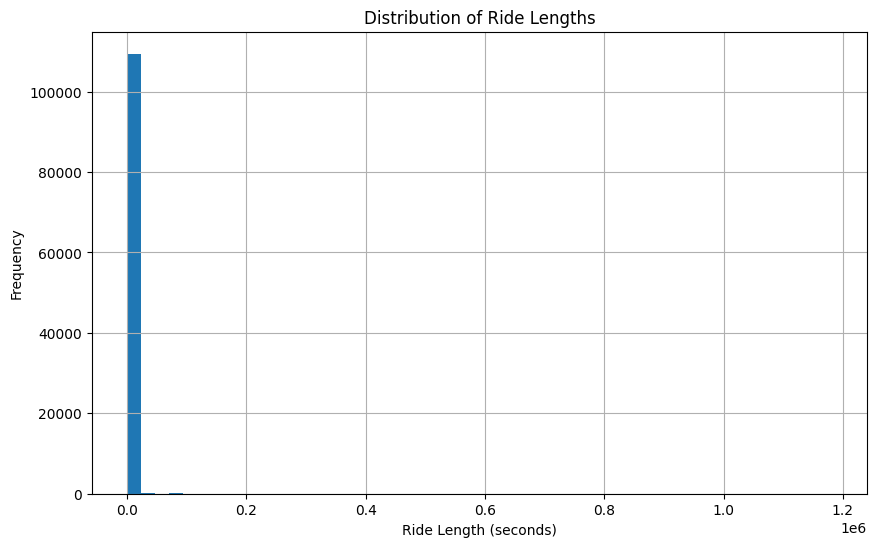

In [8]:

# Let's plot the distribution of ride durations if we have a relevant column
if 'ride_length' in df.columns:
    plt.figure(figsize=(10,6))
    df['ride_length'].hist(bins=50)
    plt.title('Distribution of Ride Lengths')
    plt.xlabel('Ride Length')
    plt.ylabel('Frequency')
    plt.show()
elif 'started_at' in df.columns and 'ended_at' in df.columns:
    df['ride_length'] = (pd.to_datetime(df['ended_at']) - pd.to_datetime(df['started_at'])).dt.total_seconds()
    plt.figure(figsize=(10,6))
    df['ride_length'].hist(bins=50)
    plt.title('Distribution of Ride Lengths')
    plt.xlabel('Ride Length (seconds)')
    plt.ylabel('Frequency')
    plt.show()




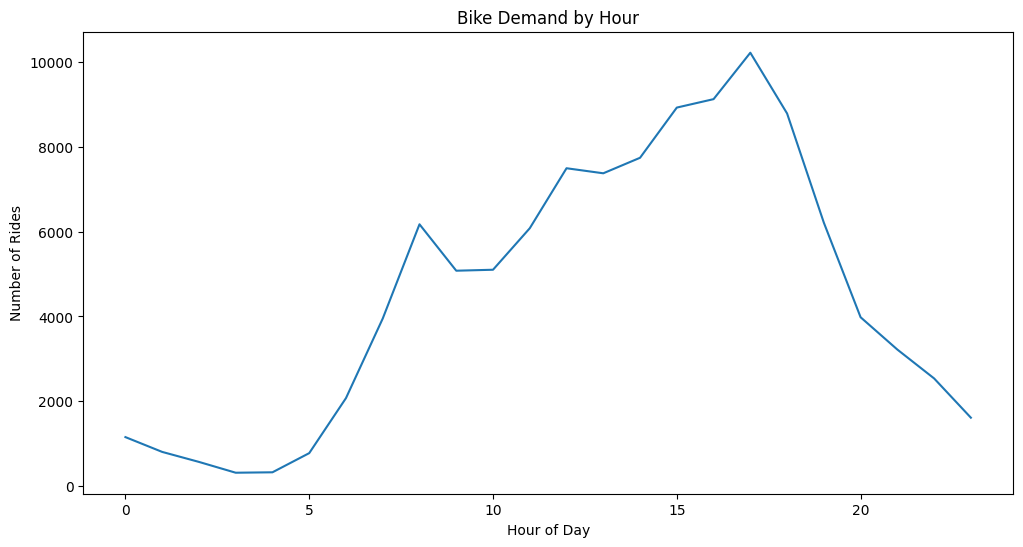

In [9]:
# Plot demand by hour
df['start_hour'] = pd.to_datetime(df['started_at']).dt.hour
hourly_demand = df['start_hour'].value_counts().sort_index()
plt.figure(figsize=(12,6))
hourly_demand.plot(kind='line')
plt.title('Bike Demand by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.show()

In [10]:
hourly_demand

start_hour
0      1153
1       804
2       568
3       313
4       323
5       775
6      2073
7      3950
8      6173
9      5078
10     5101
11     6080
12     7495
13     7376
14     7742
15     8926
16     9125
17    10220
18     8787
19     6211
20     3980
21     3218
22     2537
23     1611
Name: count, dtype: int64

##  Data Preparation Analysis

* It checks for the existence of columns before trying to use them.
* If 'duration' isn't available, it looks for 'ride_length' or calculates it from 'started_at' and 'ended_at' if those are available.
* It prints out the column names to see what data we're working with.
* It still attempts to plot the demand by the hour if the 'started_at' column is available.

* After running this, we'll better understand our dataset's structure and can proceed with the modelling steps accordingly.

## Feature Engineering

In [11]:
# Create the day-of-week features
df['day_of_week'] = pd.to_datetime(df['started_at']).dt.dayofweek
df['month'] = pd.to_datetime(df['started_at']).dt.month

# Group by station and hour to get hourly demand
hourly_station_demand = df.groupby(['start_station_name', 'start_hour', 'day_of_week', 'month']).size().reset_index(name='demand')


In [12]:
hourly_station_demand

,start_station_name,start_hour,day_of_week,month,demand
0,10th & E St NW,3,6,1,1
1,10th & E St NW,5,0,1,1
2,10th & E St NW,5,4,1,1
3,10th & E St NW,6,1,1,1
4,10th & E St NW,6,3,1,2
...,...,...,...,...,...
32834,Yuma St & Tenley Circle NW,22,3,1,1
32835,Yuma St & Tenley Circle NW,23,0,1,1
32836,Yuma St & Tenley Circle NW,23,2,1,2
32837,Yuma St & Tenley Circle NW,23,3,1,1


In [13]:
# Create start_date column
df['start_date'] = pd.to_datetime(df['started_at']).dt.date

# Create start_hour column
df['start_hour'] = pd.to_datetime(df['started_at']).dt.hour

# Create a feature for ride duration in minutes
df['ride_duration'] = (pd.to_datetime(df['ended_at']) - pd.to_datetime(df['started_at'])).dt.total_seconds() / 60

# Group by start_date and start_station_name, and count rides
df_grouped = df.groupby(['start_date', 'start_station_name', 'start_hour', 'day_of_week'])['ride_id'].count().reset_index(name='ride_count')

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_grouped, columns=['start_station_name', 'day_of_week'])

df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_length,start_hour,day_of_week,month,start_date,ride_duration
0,1B4445D591115BD9,classic_bike,2022-01-06 18:39:28,2022-01-06 18:43:03,Monroe Ave & Leslie Ave,31087.0,Potomac Ave & Main Line Blvd,31910.0,38.820932,-77.053096,38.822738,-77.049265,member,215.0,18,3,1,2022-01-06,3.583333
1,7F4A0E2F03EADEB7,classic_bike,2022-01-31 19:21:22,2022-01-31 19:27:33,14th & L St NW,31283.0,10th & G St NW,31274.0,38.903658,-77.031737,38.898243,-77.026235,member,371.0,19,0,1,2022-01-31,6.183333
2,30DD8A84164843AD,classic_bike,2022-01-07 15:28:39,2022-01-07 15:31:01,14th & L St NW,31283.0,12th & L St NW,31251.0,38.903658,-77.031737,38.903819,-77.028400,member,142.0,15,4,1,2022-01-07,2.366667
3,FC67665D7682D0A6,classic_bike,2022-01-27 20:09:25,2022-01-27 20:37:02,New York Ave & Hecht Ave NE,31518.0,Nannie Helen Burroughs & Minnesota Ave NE,31704.0,38.915604,-76.983683,38.901385,-76.941877,casual,1657.0,20,3,1,2022-01-27,27.616667
4,7854F7CC4F631A1E,classic_bike,2022-01-07 16:14:28,2022-01-07 16:16:13,Falls Church City Hall / Park Ave & Little Fal...,32608.0,Pennsylvania Ave & Park Ave,32603.0,38.885434,-77.173605,38.887403,-77.176992,member,105.0,16,4,1,2022-01-07,1.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109614,4148219E64BE2FFD,classic_bike,2022-01-05 12:48:11,2022-01-05 12:54:16,14th & V St NW,31101.0,14th & Rhode Island Ave NW,31203.0,38.917764,-77.032096,38.908600,-77.032300,casual,365.0,12,2,1,2022-01-05,6.083333
109615,946CD13F343E8664,electric_bike,2022-01-28 03:38:00,2022-01-28 03:47:54,NaN,NaN,14th & Rhode Island Ave NW,31203.0,38.930000,-77.020000,38.908600,-77.032300,casual,594.0,3,4,1,2022-01-28,9.900000
109616,30A59977329F2F8C,classic_bike,2022-01-21 07:50:24,2022-01-21 07:53:20,Adams Mill & Columbia Rd NW,31104.0,Woodley Park Metro / Calvert St & Connecticut ...,31323.0,38.922925,-77.042581,38.923389,-77.051833,member,176.0,7,4,1,2022-01-21,2.933333
109617,96CC9C99FA55DD46,classic_bike,2022-01-20 18:16:35,2022-01-20 18:33:10,14th & Otis Pl NW,31131.0,17th & P St NW,31330.0,38.934405,-77.032687,38.909858,-77.038566,member,995.0,18,3,1,2022-01-20,16.583333


In [14]:
# Select features for the model
features = ['start_hour'] + [col for col in df_encoded.columns if col.startswith('start_station_name_') or col.startswith('day_of_week_')]
X = df_encoded[features]
y = df_encoded['ride_count']

In [15]:
# Split the data and scale features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Train the initial model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")


Mean Squared Error: 2.9231922217001603e+22
R-squared Score: -2.2070296907395025e+22


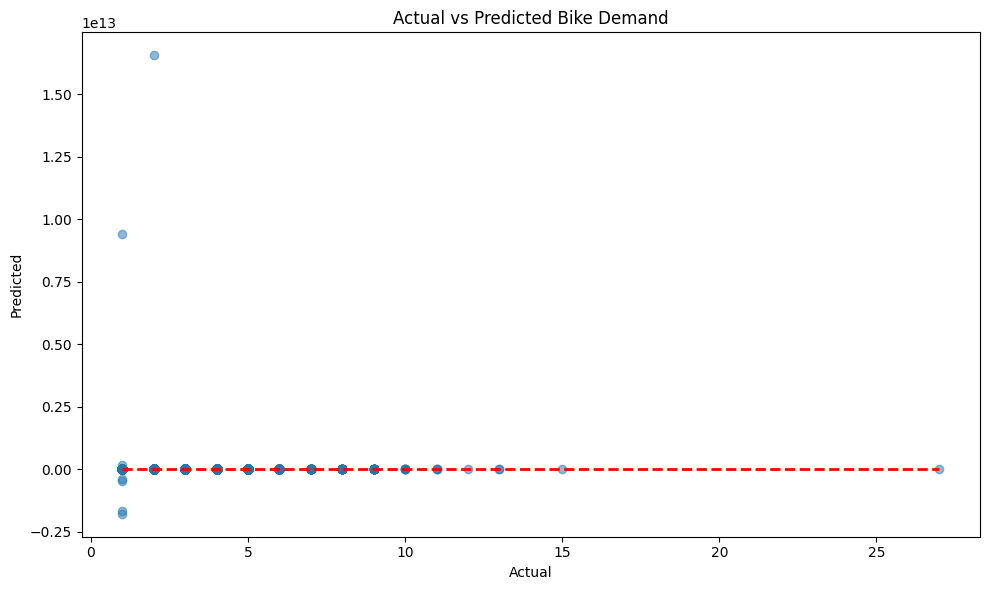

In [17]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Bike Demand')
plt.tight_layout()
plt.show()

## Split the data and scale feature

## Model Creation and Trainning

## Model Optimization

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso

# Ridge Regression
ridge_params = {'alpha': [0.1, 1.0, 10.0]}
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5)
ridge_cv.fit(X_train_scaled, y_train)

print("Best Ridge parameters:", ridge_cv.best_params_)
print("Best Ridge score:", ridge_cv.best_score_)

# Lasso Regression
lasso_params = {'alpha': [0.1, 1.0, 10.0]}
lasso = Lasso()
lasso_cv = GridSearchCV(lasso, lasso_params, cv=5)
lasso_cv.fit(X_train_scaled, y_train)

print("Best Lasso parameters:", lasso_cv.best_params_)
print("Best Lasso score:", lasso_cv.best_score_)

# Choose the best model
best_model = ridge_cv if ridge_cv.best_score_ > lasso_cv.best_score_ else lasso_cv
print("The Best Model: ", best_model)

Best Ridge parameters: {'alpha': 10.0}
Best Ridge score: 0.12893514901205977
Best Lasso parameters: {'alpha': 0.1}
Best Lasso score: 0.009645259254827798
The Best Model:  GridSearchCV(cv=5, estimator=Ridge(), param_grid={'alpha': [0.1, 1.0, 10.0]})


## Basic Model Optimization

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
rf_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Create a Random Forest regressor
rf = RandomForestRegressor(random_state=42)

# Perform randomized search cross-validation
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=rf_params, 
                               n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train_scaled, y_train)

print("Best Random Forest parameters:", rf_random.best_params_)
print("Best Random Forest score:", rf_random.best_score_)

# Make predictions
y_pred_rf = rf_random.predict(X_test_scaled)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest R-squared: {r2_rf}")

# Feature importance
importances = rf_random.best_estimator_.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(importances, X.columns), reverse=True), 
                           columns=['Importance', 'Feature'])
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_imp.head(10))
plt.title("Top 10 Feature Importance in Random Forest Model")
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False]
}

# Perform grid search
grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Print best parameters
print("Best parameters:", grid_search.best_params_)

# Use best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)

# Evaluate best model
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Best Model - Mean Squared Error: {mse_best}")
print(f"Best Model - R-squared Score: {r2_best}")

## Model Optimization

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso

# Ridge Regression
ridge_params = {'alpha': [0.1, 1.0, 10.0]}
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5)
ridge_cv.fit(X_train_scaled, y_train)

print("Best Ridge parameters:", ridge_cv.best_params_)
print("Best Ridge score:", ridge_cv.best_score_)

# Lasso Regression
lasso_params = {'alpha': [0.1, 1.0, 10.0]}
lasso = Lasso()
lasso_cv = GridSearchCV(lasso, lasso_params, cv=5)
lasso_cv.fit(X_train_scaled, y_train)

print("Best Lasso parameters:", lasso_cv.best_params_)
print("Best Lasso score:", lasso_cv.best_score_)

# Choose the best model
best_model = ridge_cv if ridge_cv.best_score_ > lasso_cv.best_score_ else lasso_cv

In [ ]:
## Evaluate the best model

In [ ]:
y_pred_best = best_model.predict(X_test_scaled)

mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Best Model Mean Squared Error: {mse_best}")
print(f"Best Model R-squared Score: {r2_best}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Bike Demand')
plt.tight_layout()
plt.show()

## Random Forest

Certainly! I'll explain Random Forests and Gradient Boosting in more detail, including how to implement them for our bike demand prediction problem.
Random Forests:
Random Forests are an ensemble learning method that operates by constructing multiple decision trees during training and outputting the mean prediction of the individual trees for regression tasks.
Key features:

Handles non-linear relationships well
Less prone to overfitting compared to single decision trees
Provides feature importance

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
rf_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Create a Random Forest regressor
rf = RandomForestRegressor(random_state=42)

# Perform randomized search cross-validation
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=rf_params, 
                               n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train_scaled, y_train)

print("Best Random Forest parameters:", rf_random.best_params_)
print("Best Random Forest score:", rf_random.best_score_)

# Make predictions
y_pred_rf = rf_random.predict(X_test_scaled)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest R-squared: {r2_rf}")

# Feature importance
importances = rf_random.best_estimator_.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(importances, X.columns), reverse=True), 
                           columns=['Importance', 'Feature'])
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_imp.head(10))
plt.title("Top 10 Feature Importance in Random Forest Model")
plt.tight_layout()
plt.show()

## Gradient Boosting
Gradient Boosting:
Gradient Boosting is another ensemble technique that builds trees sequentially, where each new tree corrects the errors of the previous ones.
Key features:

Often provides higher accuracy than Random Forests
Can be prone to overfitting if not tuned properly
Generally slower to train than Random Forests

Here's how to implement Gradient Boosting (using XGBoost) for our problem:



In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
xgb_params = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400, 500],
    'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
    'subsample': [0.6, 0.8, 1.0]
}

# Create an XGBoost regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Perform randomized search cross-validation
xgb_random = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_params, 
                                n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
xgb_random.fit(X_train_scaled, y_train)

print("Best XGBoost parameters:", xgb_random.best_params_)
print("Best XGBoost score:", xgb_random.best_score_)

# Make predictions
y_pred_xgb = xgb_random.predict(X_test_scaled)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MSE: {mse_xgb}")
print(f"XGBoost R-squared: {r2_xgb}")

# Feature importance
xgb.plot_importance(xgb_random.best_estimator_, max_num_features=10)
plt.title("Top 10 Feature Importance in XGBoost Model")
plt.tight_layout()
plt.show()

Random Forests and Gradient Boosting often perform better than simple linear models for complex problems like bike demand prediction. They can capture non-linear relationships and interactions between features.
Key differences:

Random Forests build trees in parallel, while Gradient Boosting builds them sequentially.
Gradient Boosting often achieves higher accuracy but is more prone to overfitting.
Random Forests are generally easier to tune and less sensitive to outliers.

When using these models, consider:

Feature importance analysis to understand key drivers of bike demand.
Cross-validation to ensure the model generalizes well.
Hyperparameter tuning to optimize model performance.
Balancing model complexity with interpretability based on your needs.